# AP-1 Peak Calling

In [7]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

In [15]:
# file directories
workingDirectory = '/home/jenhan/analysis/ap1_analysis/'
peakDirectory = '/home/jenhan/analysis/ap1_analysis/peak_files/'
scratchDirectory = '/home/jenhan/analysis/ap1_analysis/scratch'
logFilePath = '/home/jenhan/analysis/ap1_analysis/log_files/'
tagDirPath = '/home/jenhan/analysis/ap1_analysis/tag_directories/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'

os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
if not os.path.isfile("nameMapping.tsv"):
    nameMappingFile = open("nameMapping.tsv", "w")
    for f in os.listdir(logFilePath):
        rootName = f.replace('.fastq.mm10.bowtie2.log','')
        nameMappingFile.write(rootName + '\t' + rootName + '\n')
    nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
cellTypes = []
experiments = []
factors = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    
    # grab metadata from string tokens
    strain = metaDataTokens[0]
    cellType = metaDataTokens[1]
    experiment = metaDataTokens[2]
    factor = metaDataTokens[3]
    treatment = metaDataTokens[4]
    owner = metaDataTokens[5]
    date = metaDataTokens[6]
    
    # append to overall lists
    strains.append(strain)
    cellTypes.append(cellType)
    experiments.append(experiment)
    factors.append(factor)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  cellTypes, 
                                  experiments, 
                                  factors, treatments, 
                                  owners, 
                                  dates, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'cellType', 
                         'experiment', 
                         'factor', 
                         'treatment', 
                         'owner', 
                         'date', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.lower().replace('-1h','').replace('dsgfa-','')
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["originalName"])) # {newName:originalName}

### read in log files ###

# create data frame summarizing mapping quality logs
# _sampleNames = []
_totalReads = []
_unpairedReads = []
_unmappedReads = []
_uniquelyMappedReads = []
_multiMappedReads = []
_originalNames =[]
for logFile in os.listdir(logFilePath):
    with open(logFilePath + '/' + logFile) as f:
        data = f.readlines()
        
    rootName = logFile.replace('.fastq.mm10.bowtie2.log','')
#     sampleName = originalName_cleanedName_dict[rootName]
    
    totalReads = int(data[0].split()[0])
    unpairedReads = int(data[1].split()[0])
    unmappedReads = int(data[2].split()[0])
    uniquelyMappedReads = int(data[3].split()[0])
    multiMappedReads = int(data[4].split()[0])

    _originalNames.append(rootName)
#     _sampleNames.append(sampleName)
    _totalReads.append(totalReads)
    _unpairedReads.append(unpairedReads)
    _unmappedReads.append(unmappedReads)
    _uniquelyMappedReads.append(uniquelyMappedReads)
    _multiMappedReads.append(multiMappedReads)

mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 
                                   _unpairedReads, 
                                   _unmappedReads, 
                                   _uniquelyMappedReads, 
                                   _multiMappedReads]).transpose()
mappingStats_frame.columns = ['originalName',
                              'totalReads', 
                              'unpairedReads', 
                              'unmappedReads', 
                              'uniquelyMappedReads', 
                              'multiMappedReads']

# calculate fractions from read counts
mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []

# read in pbc values
sampleName_pbc_dict = {} # {sampleName: pbc valeue}
# with open ("ap1_pbc.tsv") as f:
#     data = f.readlines()
# for line in data:
#     tokens = line.strip().split('\t')
#     sampleName = tokens[0]
#     pbcValue = float(tokens[1])
#     sampleName_pbc_dict[sampleName] = pbcValue
# mappingStats_frame['pbc'] = [sampleName_pbc_dict[x] for x in mappingStats_frame['originalName']]
    
for simpleNameRoot in list((metadata_frame['strain'] + '_' + metadata_frame['factor'] + '_' + metadata_frame["simpleTreatment"]).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot])).lower()
    simplifiedNames.append(simplifiedName)

metadata_frame["simplifiedName"] = simplifiedNames
    
sampleName_simpleName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(metadata_frame["simplifiedName"], metadata_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(metadata_frame["simplifiedName"], metadata_frame["originalName"])) 

summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')
summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['factor'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()

## Peak Calling

In [16]:
veh_input_dict = {'14-03-17':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '14-06-24':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '14-08-07':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '15-02-06':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/',
                  '15-06-29':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20/'
                  }
kla_input_dict = {'14-03-17':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '14-06-24':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '14-08-07':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '15-02-06':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/',
                  '15-06-29':'/home/jenhan/analysis/ap1_analysis/input_data/input_tagDir/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20/'
                  }
veh_bamInput_dict = {'14-03-17':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '14-06-24':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '14-08-07':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '15-02-06':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '15-06-22':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_Veh_GJF_15_03_20.fastq.mm10.bowtie2.bam'
                  }
kla_bamInput_dict = {'14-03-17':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '14-06-24':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '14-08-07':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '15-02-06':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20.fastq.mm10.bowtie2.bam',
                  '15-06-22':'/home/jenhan/analysis/ap1_analysis/input_data/input_bam/Sample_C57Bl_6_ThioMac_ChIP_Input_KLA_1h_GJF_15_03_20.fastq.mm10.bowtie2.bam'
                  }

In [17]:
sorted(set(summary_frame['date'].values))

['14-03-17',
 '14-06-24',
 '14-08-07',
 '15-02-06',
 '15-05-20',
 '15-06-29',
 '15-08-18',
 '15-10-19']

### Homer

In [23]:
%%capture 
# suppress output - this can be saved to a variable (like a log file)

### call peaks ###
# iterate through each individual file
if not os.path.exists(peakDirectory):
    os.makedirs(peakDirectory)

# make peak files with simplified names
# filteredSamples = list(filtered_mappingStats_frame['sampleName'].values)
scriptFile = open(scratchDirectory + '/peakCalling_homer.sh', 'w')
for tagDir in os.listdir(tagDirPath):
    # call peaks only for experiments that passed thresholding
    metaDataTokens = originalName_cleanedName_dict[tagDir].split("_")
    treatment = metaDataTokens[4]
    date = metaDataTokens[6]

    peakFileName = originalName_simpleName_dict[tagDir] + "_homer_peaks.tsv"
    if "veh" in treatment.lower():
        inputDir = veh_input_dict[date]
    elif "kla" in treatment.lower():
            inputDir = kla_input_dict[date]
#     scriptFile.write('findPeaks ' + tagDirPath + '/' + tagDir + 
#                      ' -i ' + inputDir + 
#                      ' -L 0 -C 0 -fdr 0.9 -style factor -size 100  > ' + 
#                      peakDirectory +'/' + peakFileName + ' &\n')
    scriptFile.write('findPeaks ' + tagDirPath + '/' + tagDir + 
                     ' -i ' + inputDir + 
                     ' -style factor -size 100  > ' + 
                     peakDirectory +'/' + peakFileName + ' &\n')
scriptFile.close()
! bash $scratchDirectory/peakCalling_homer.sh



In [49]:
### annotate peaks with tag counts ###
if not os.path.exists(scratchDirectory):
    os.mkdir(scratchDirectory)

scriptFile = open(scratchDirectory + '/homer_peak_annotation.sh', 'w')

count = 0 
sleepTime = 0
peakFiles = os.listdir(peakDirectory)
for peakFile in peakFiles:
    if "homer" in peakFile:
        annotatedFile = peakFile.replace("_homer_peaks.tsv","") + "_homer_annotated.tsv"
        simpleName_sampleName_dict[peakFile.replace("_homer_peaks.tsv","")]
        tagDir1 = cleanedName_originalName_dict[simpleName_sampleName_dict[peakFile.replace("_homer_peaks.tsv","")]]
        # annotate peaks with tag counts
        count += 1
        if count == 10:
            count = 0
            sleepTime += 1
        scriptFile.write('(sleep ' + str(sleepTime) +'m; annotatePeaks.pl '+
                         peakDirectory + '/' + peakFile +
                         ' mm10 -noadj -noann -nogene -d ' +
                         tagDirPath + '/' + tagDir1 + '> ' +
                         scratchDirectory + '/' + annotatedFile +') & \n')
scriptFile.close()

# run script
! bash $scratchDirectory/homer_peak_annotation.sh

In [6]:
### calculate SPOT coefficient
sampleName_mappedReadsDict = dict(zip(summary_frame['originalName'], summary_frame['totalReads'] - summary_frame['unmappedReads']))
sampleName_spot_dict = {}
mappedReadsInPeaks = []
for p in os.listdir(scratchDirectory):
    if 'homer_annotated' in p:
        with open(scratchDirectory + '/' + p) as f:
            data = f.readlines()
        simpleName = p.replace('_homer_annotated.tsv','')
        originalName = simpleName_originalName_dict[simpleName]
        totalTagCount = 0
        for line in data[1:]: # first line is head
            # last column in annotated file gives tag counts
            tokens = line.strip().split("\t")
            tagCount = float(tokens[-1])
            totalTagCount +=tagCount
            totalMappedReads = sampleName_mappedReadsDict[originalName]
            spot = totalTagCount/totalMappedReads
        mappedReadsInPeaks.append(totalTagCount)
        sampleName_spot_dict[originalName] = spot
summary_frame['spot'] = [sampleName_spot_dict[x] for x in summary_frame['originalName'].values]

### SPP

In [ ]:
# suppress output - this can be saved to a variable (like a log file)
scriptFile = open(scratchDirectory + '/peakCalling_spp.sh', 'w')

# loop through all samples    
count = 0
for index, row in summary_frame.iterrows():
    originalName = row["originalName"]
    peakFileName = row["simplifiedName"] + '_spp'
    
    metaDataTokens = row['sampleName'].split("_")
    treatment = metaDataTokens[4]
    date = metaDataTokens[6]
    
    if "veh" in treatment.lower():
        inputBam = veh_bamInput_dict[date]
    elif "kla" in treatment.lower():
        inputBam = kla_bamInput_dict[date]
    scriptFile.write('(sleep ' + str(count) + 'm; mkdir ' + peakDirectory + '/' + peakFileName + '; Rscript ' + binDirectory + '/phantompeakqualtools/run_spp.R' + 
                     ' -c=' + bamDirectory + '/' + originalName + '.fastq.mm10.bowtie2.bam' +
                     ' -i=' + inputBam + 
                     ' -npeak=200000' +
                     ' -odir=' + peakDirectory + '/' + peakFileName + 
                     ' -out=' + peakDirectory + '/' + peakFileName + '/' + peakFileName + '.out'
                     ' -p=8 -savn -savr -savp -savd -rf)&\n')
    count += 30
scriptFile.close()
! bash $scratchDirectory/peakCalling_spp.sh 

### GEM

In [ ]:
### GEM peak calling ###
scriptFile = open(scratchDirectory + '/peakCalling_gem.sh', 'w')

# loop through all samples    
count = 0
for index, row in summary_frame.iterrows():
    originalName = row["originalName"]
    peakFileName = row["simplifiedName"] + '_gem'
    
    metaDataTokens = row['sampleName'].split("_")
    treatment = metaDataTokens[4]
    date = metaDataTokens[6]
    
    if "veh" in treatment.lower():
        inputBam = veh_bamInput_dict[date]
    elif "kla" in treatment.lower():
        inputBam = kla_bamInput_dict[date]
    scriptFile.write('(sleep ' + str(count) + 'm; java -Xmx10G -jar ' + binDirectory + '/gem/gem.jar' + 
                     ' --d ' + binDirectory + '/gem/Read_Distribution_default.txt' +
                     ' --genome ' + genomePath +
                     ' --g ' + genomePath + '/chrom.sizes' +
                     ' --expt ' + bamDirectory + '/' + originalName + '.fastq.mm10.bowtie2.bam' +
                     ' --ctrl ' + inputBam + 
                     ' --f SAM --outNP' +
                     ' --out ' + peakDirectory + '/' +peakFileName +
                     ')&\n')
    count += 15
scriptFile.close()

# ! bash $scratchDirectory/peakCalling_gem.sh

### MACS

In [ ]:
%%capture 
### MACS peak calling ##
# suppress output - this can be saved to a variable (like a log file)

scriptFile = open(scratchDirectory + '/peakCalling_macs.sh', 'w')

# loop through all samples    
count = 0
for index, row in summary_frame.iterrows():
    originalName = row["originalName"]
    peakFileName = row["simplifiedName"] + '_macs'
    
    metaDataTokens = row['sampleName'].split("_")
    treatment = metaDataTokens[4]
    date = metaDataTokens[6]
    
    if "veh" in treatment.lower():
        inputBam = veh_bamInput_dict[date]
    elif "kla" in treatment.lower():
        inputBam = kla_bamInput_dict[date]
    scriptFile.write('(sleep ' + str(count) + 'm; macs2 callpeak' +
                     ' -t ' + bamDirectory + '/' + originalName + '.fastq.mm10.bowtie2.bam' +
                     ' -c ' + inputBam + 
                     ' -n ' + peakFileName +
                     ' --outdir ' + peakDirectory + '/' + peakFileName + 
                     ' -f BAM -g 1.87e9 -q 0.01)&\n')
#     count += 15
scriptFile.close()
! bash $scratchDirectory/peakCalling_macs.sh


## Mapping Quality Control

### Plot Distributions of Mapping Statistics

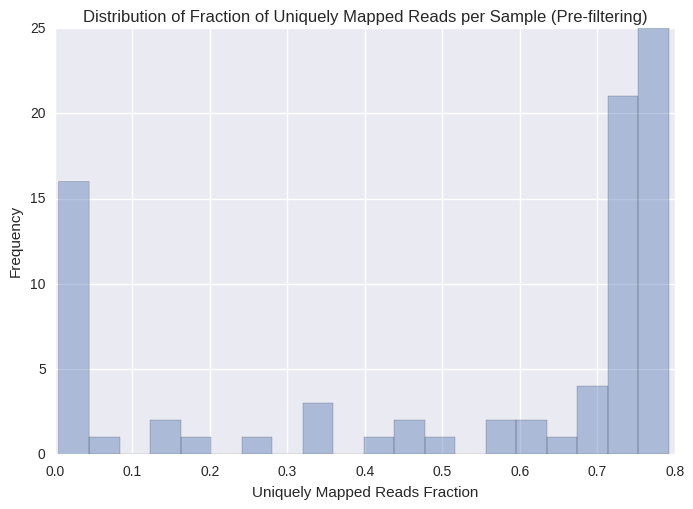

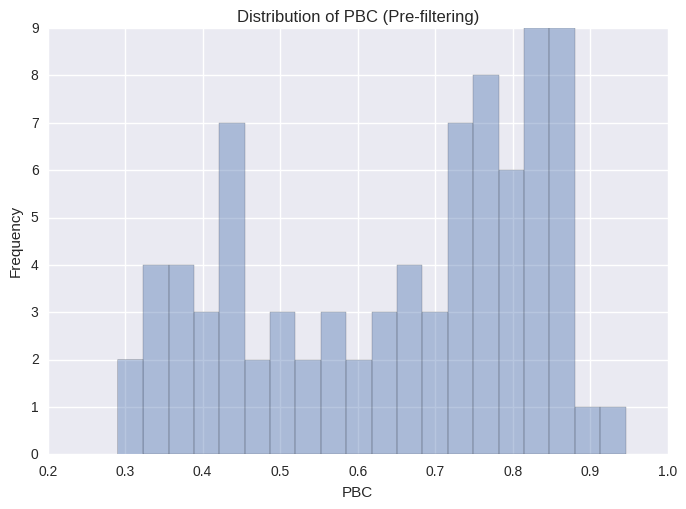

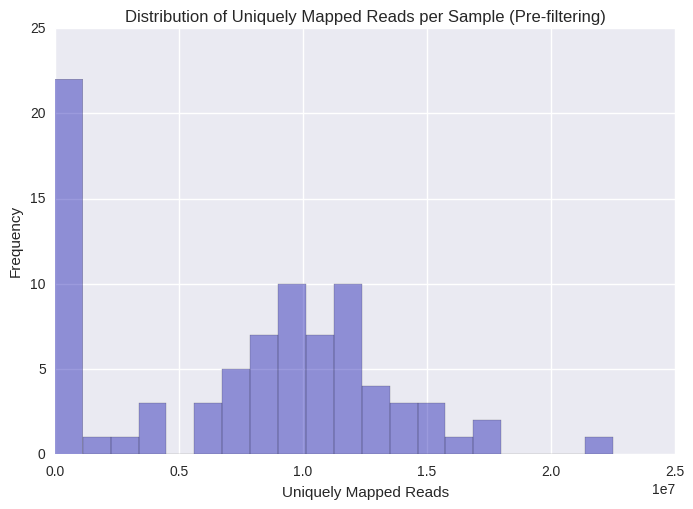

TypeError: lmplot() got an unexpected keyword argument 'dtype'

In [10]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# plot distribution of PBC
sns.distplot(summary_frame['pbc'], bins=20, kde=False)
plt.title('Distribution of PBC (Pre-filtering)')
plt.xlabel('PBC')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.lmplot(x='totalReads', y='uniquelyMappedReads', data= summary_frame)
plt.show()

sns.lmplot(x='uniquelyMappedFraction', y='pbc', data= summary_frame)
plt.show()

# sns.distplot(summary_frame['spot'], kde=False, bins =50)
# plt.show()

TypeError: No loop matching the specified signature and casting
was found for ufunc svd_n_s

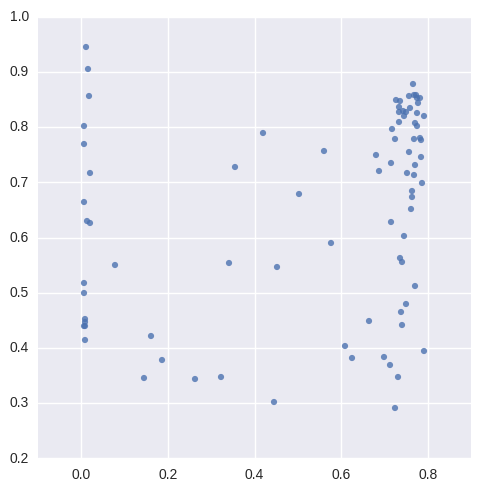

In [7]:
sns.lmplot(x='uniquelyMappedFraction', y='pbc', data= summary_frame)



### Filter Samples According to Mapping Quality

In [6]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.6
uniquelyMappedReadThreshold = 10000000
pbcThreshold=0.5
spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]
print(filtered_summary_frame.shape)
#filter on PBC
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['pbc'] >= pbcThreshold]
print(filtered_summary_frame.shape)
#filter on spot
filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['spot'] >= spotThreshold]
print(filtered_summary_frame.shape)

# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

(32, 19)
(24, 19)


KeyError: 'spot'

<function xticks at 0x7fb489a74ae8>


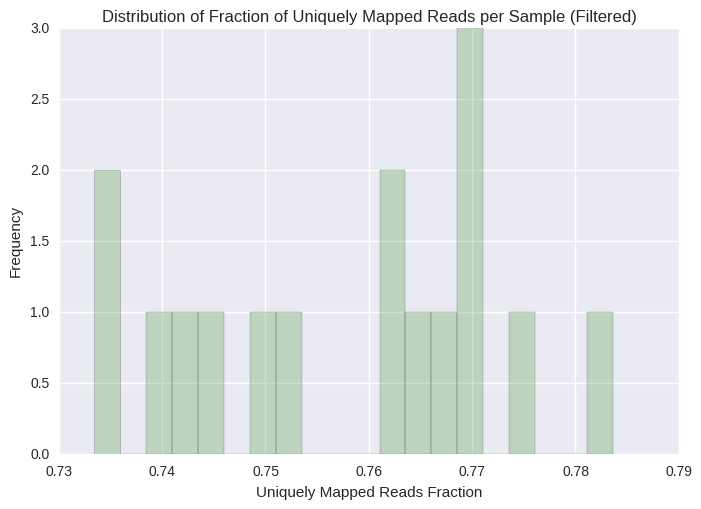

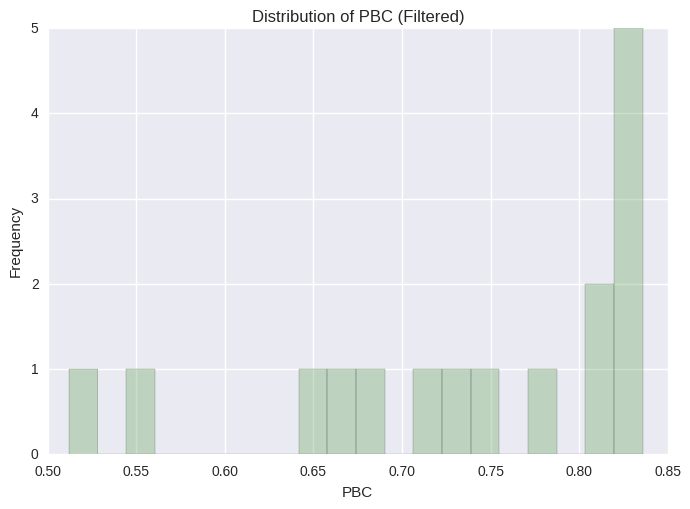

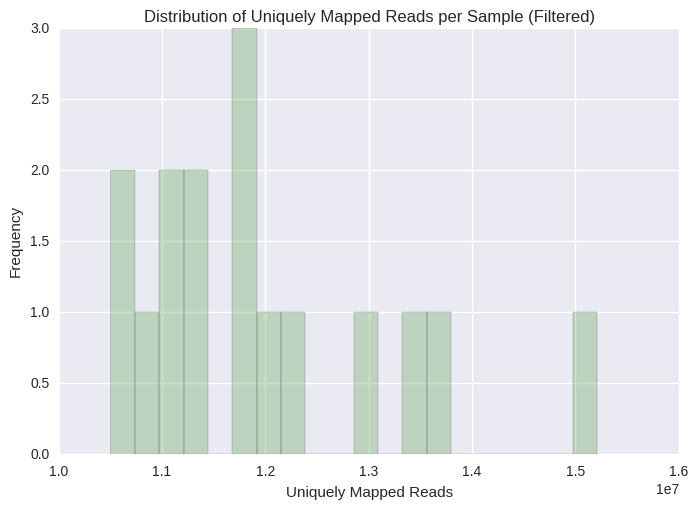

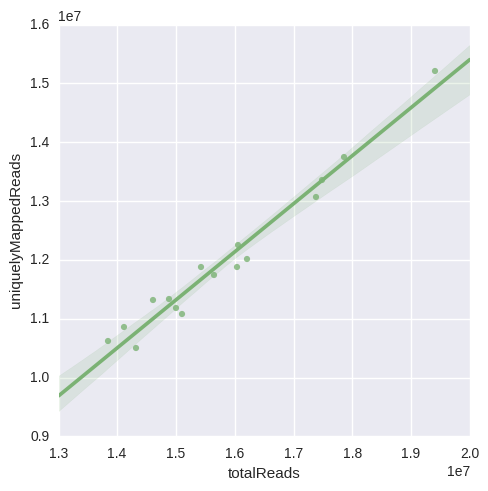

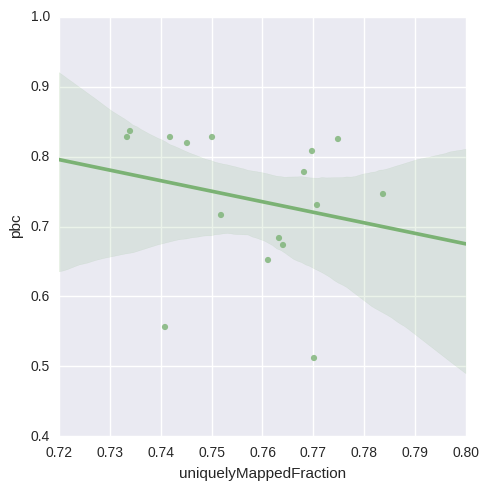

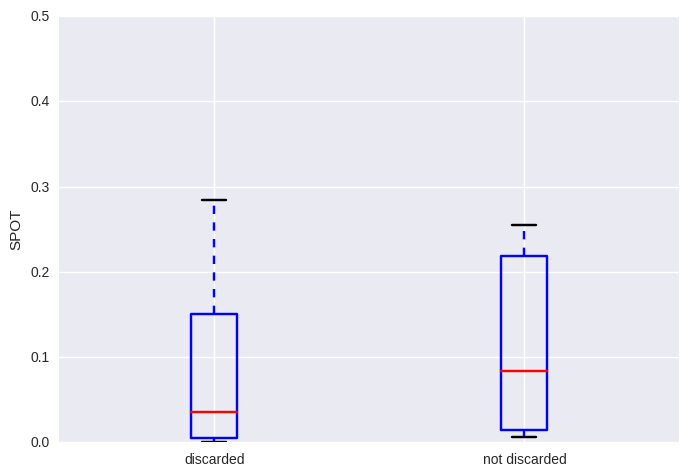

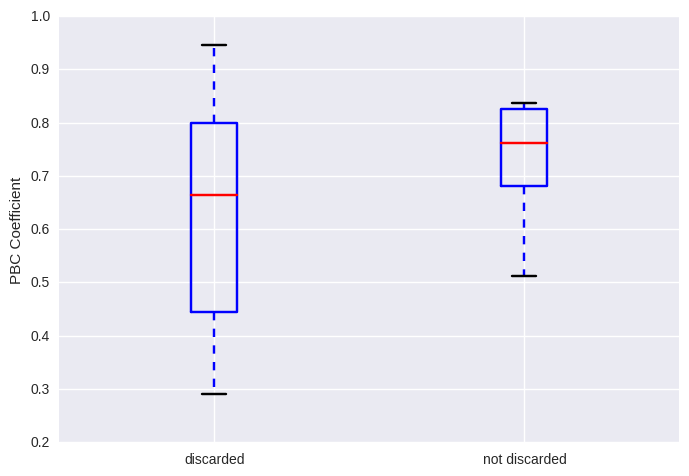

In [68]:
# plot distribution of uniquely mapped reads
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
print(plt.xticks)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Filtered)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# plot distribution of PBC
sns.distplot(filtered_summary_frame['pbc'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
plt.title('Distribution of PBC (Filtered)')
plt.xlabel('PBC')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Filtered)')
plt.xlabel('Uniquely Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.lmplot(x='totalReads', y='uniquelyMappedReads', data= filtered_summary_frame, color=sns.xkcd_rgb['faded green'])
plt.show()

sns.lmplot(x='uniquelyMappedFraction', y='pbc', data= filtered_summary_frame, color=sns.xkcd_rgb['faded green'])
plt.show()

plt.boxplot([discarded_summary_frame["spot"], filtered_summary_frame["spot"]])
plt.xticks([1, 2], ["discarded", "not discarded"])
plt.ylabel("SPOT")
plt.show()

plt.boxplot([discarded_summary_frame["pbc"], filtered_summary_frame["pbc"]])
plt.ylabel("PBC Coefficient")
plt.xticks([1, 2], ["discarded", "not discarded"])
plt.show()

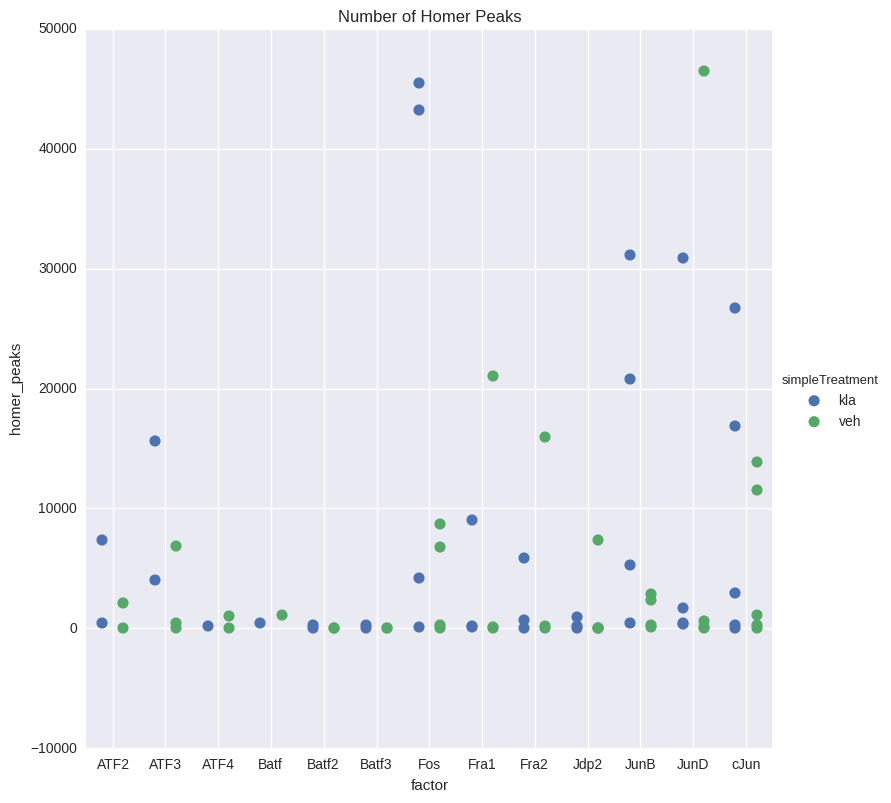

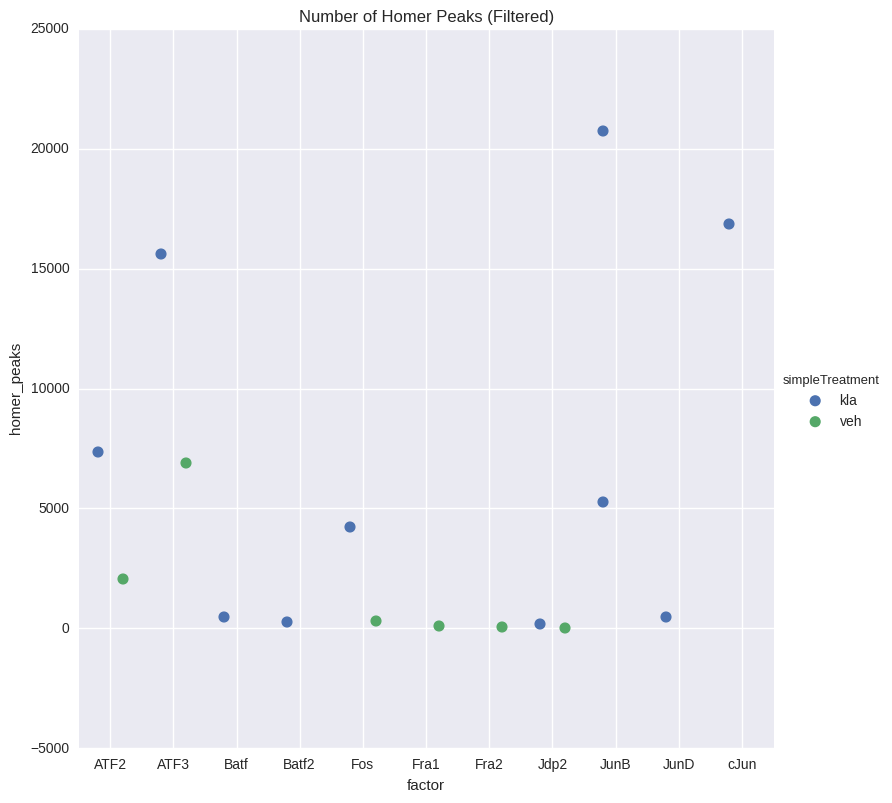

In [69]:
# summarize the number of peaks
# plot the number of peaks vs the number 

# Homer
sampleName_homer_peakNumber_dict = {}
for p in os.listdir(peakDirectory):
    if "homer" in p:
        with open(peakDirectory + '/' + p) as f:
            data = f.readlines()
        numPeaks = len(data) - 40
        simpleName = p.replace('_homer_peaks.tsv','')
        sampleName_homer_peakNumber_dict[simpleName] = numPeaks
        
filtered_summary_frame["homer_peaks"] = [sampleName_homer_peakNumber_dict[x] for x in filtered_summary_frame["simplifiedName"]]
summary_frame["homer_peaks"] = [sampleName_homer_peakNumber_dict[x] for x in summary_frame["simplifiedName"]]

sns.factorplot(x="factor", y="homer_peaks", 
               hue='simpleTreatment', 
               data=summary_frame[summary_frame['simpleTreatment'].isin(['veh','kla'])], 
               kind="strip", 
               size=8)

plt.grid(b=True, which='both')
plt.title("Number of Homer Peaks")
plt.show()

sns.factorplot(x="factor", y="homer_peaks", hue='simpleTreatment', 
               data=filtered_summary_frame[filtered_summary_frame['simpleTreatment'].isin(['veh','kla'])], 
               kind="strip", 
               size=8)
plt.grid(b=True, which='both')
plt.title("Number of Homer Peaks (Filtered)")
plt.show()
# # # GEM
# sampleName_gem_peakNumber_dict = {}
# for p in os.listdir(peakDirectory):
#     if "gem" in p:
#         with open(peakDirectory + '/' + p + '/' + p + '_GPS_events.txt') as f:
#             data = f.readlines()
#         numPeaks = np.max([0,len(data) - 1])
#         simpleName = p.replace('_gem','')
#         sampleName_gem_peakNumber_dict[simpleName] = numPeaks
        
# filtered_summary_frame["gem_peaks"] = [sampleName_gem_peakNumber_dict[x] for x in filtered_summary_frame["simplifiedName"]]
# summary_frame["gem_peaks"] = [sampleName_gem_peakNumber_dict[x] for x in summary_frame["simplifiedName"]]

# sns.factorplot(x="factor", y="gem_peaks", hue='simpleTreatment', data=filtered_summary_frame, kind="strip", size=8)
# plt.title("Number of GEM Peaks")
# plt.grid(b=True, which='both')
# plt.ylim([0,50000])
# plt.show()

# # MACS
# sampleName_macs_peakNumber_dict = {}
# for p in os.listdir(peakDirectory):
#     if "macs" in p:
#         macsFilePath = peakDirectory + '/' + p + '/' + p + '_peaks.narrowPeak'
#         if os.path.isfile(macsFilePath):
#             with open(macsFilePath) as f:
#                 data = f.readlines()
#             numPeaks = len(data)
#         else:
#             numPeaks = 0
#         simpleName = p.replace('_macs','')
#         sampleName_macs_peakNumber_dict[simpleName] = numPeaks
        
# filtered_summary_frame["macs_peaks"] = [sampleName_macs_peakNumber_dict[x] for x in filtered_summary_frame["simplifiedName"]]
# summary_frame["macs_peaks"] = [sampleName_macs_peakNumber_dict[x] for x in summary_frame["simplifiedName"]]


# sns.factorplot(x="factor", y="macs_peaks", hue='simpleTreatment', data=filtered_summary_frame, kind="strip", size=8)
# plt.ylim([0,50000])
# plt.grid(b=True, which='both')
# plt.title("Number of MACS Peaks")
# plt.show()

# SPP




## Tag Scatter Plots (for peaks called by each tool)

### Homer

In [ ]:
%%capture 
# for every pair of peak files with the same factor
if not os.path.exists(scratchDirectory):
    os.mkdir(scratchDirectory)

# remove empty files
if os.path.exists(scratchDirectory):
    for f in os.listdir(scratchDirectory):
        if os.stat(scratchDirectory + '/' + f).st_size == 0 and 'merged' in f:
            os.remove(scratchDirectory + '/' + f)  

scriptFile = open(scratchDirectory + '/peakMerging.sh', 'w')
  
peakFiles = os.listdir(peakDirectory)
for i in range(len(peakFiles)-1):
    for j in range(i+1, len(peakFiles)): 
        # merge the peaks together
        peakFile1 = peakFiles[i]
        peakFile2 = peakFiles[j]
        mergedFile = peakFile1.replace("_homer_peaks.tsv","") + "_" + peakFile2.replace("_homer_peaks.tsv","") + "_homer_merged.tsv"
        if not os.path.isfile(scratchDirectory + '/' + mergedFile):
            scriptFile.write('mergePeaks -d given ' +
                             peakDirectory + '/' + peakFile1 + ' ' +
                             peakDirectory + '/' + peakFile2 +
                             ' > ' + scratchDirectory + '/' + mergedFile + '&\n')
scriptFile.close()

# run script
! bash $scratchDirectory/peakMerging.sh

In [ ]:
%%capture
if not os.path.exists(scratchDirectory):
    os.mkdir(scratchDirectory)

# delete all empty files
if os.path.exists(scratchDirectory):
    for f in os.listdir(scratchDirectory):
        if os.stat(scratchDirectory + '/' + f).st_size == 0 and 'annotated' in f:
            os.remove(scratchDirectory + '/' + f)

scriptFile = open(scratchDirectory + '/peakAnnotation.sh', 'w')

count = 0 
sleepTime = 0
peakFiles = os.listdir(peakDirectory)
for i in range(len(peakFiles)-1):
    for j in range(i+1, len(peakFiles)): 
        # merge the peaks together
        peakFile1 = peakFiles[i]
        peakFile2 = peakFiles[j]
        mergedFile = peakFile1.replace("_homer_peaks.tsv","") + "_" + peakFile2.replace("_homer_peaks.tsv","") + "_homer_merged.tsv"       
        annotatedFile = peakFile1.replace("_homer_peaks.tsv","") + "_" + peakFile2.replace("_homer_peaks.tsv","") + "_homer_annotated.tsv"
        tagDir1 = nameMappingDict_reverse[simpleName_sampleName_dict[peakFile1.replace("_homer_peaks.tsv","")]]
        tagDir2 = nameMappingDict_reverse[simpleName_sampleName_dict[peakFile2.replace("_homer_peaks.tsv","")]]
        # annotate peaks with tag counts
        if not os.path.isfile(scratchDirectory + '/' + annotatedFile):
            count += 1
            if count == 10:
                count = 0
                sleepTime += 1
            scriptFile.write('(sleep ' + str(sleepTime) +'m; annotatePeaks.pl '+
                             scratchDirectory + '/' + mergedFile +
                             ' mm10 -noann -nogene -d ' +
                             tagDirPath + '/' + tagDir1 + ' ' +
                             tagDirPath + '/' + tagDir2 + '> ' +
                             scratchDirectory + '/' + annotatedFile +') & \n')
scriptFile.close()

# run script
! bash $scratchDirectory/peakAnnotation.sh

In [ ]:
%%capture 
if not os.path.exists(scatterPlotDirectory):
    os.mkdir(scatterPlotDirectory)
    
if os.path.exists(scatterPlotDirectory):
    for f in os.listdir(scatterPlotDirectory):
        if 'tagScatter' in f:
            os.remove(scatterPlotDirectory + '/' + f)
            
annotatedFiles = [x for x in os.listdir(scratchDirectory) if "annotated" in x]
for af in annotatedFiles:
    tokens = af.replace("_homer_annotated.tsv","").split("_")
    sample1 = '_'.join(tokens[:3])
    sample2 = '_'.join(tokens[3:])
    annotated_frame = pd.read_csv(scratchDirectory + '/' + af, sep = '\t')
    tag_frame = annotated_frame.ix[:,-2:]
    tag_frame.columns = [sample1, sample2]
    tag_frame[sample1+'_log'] = np.log2(tag_frame[sample1])
    tag_frame[sample2+'_log'] = np.log2(tag_frame[sample2])
    tag_frame = tag_frame.replace([np.inf, -np.inf], np.nan).fillna(-1)
    # create scatter plots - save these don't display them
    # unlogged version
    sns.jointplot(x=sample1, y=sample2, data = tag_frame, space=0)
    plt.savefig(scatterPlotDirectory + '/' + af.replace("_homer_annotated.tsv","_tagScatter.png"))
    plt.close()
    # log version
    sns.jointplot(x=sample1 + '_log', y=sample2 + '_log', data = tag_frame, space=0)
    plt.savefig(scatterPlotDirectory + '/' + af.replace("_homer_annotated.tsv","_tagScatter_log.png"))
    plt.close()


In [53]:
# create heatmap/clustermap representationif not os.path.exists(scatterPlotDirectory):
simpleNames = [sampleName_simpleName_dict[x].lower() for x in filtered_summary_frame["sampleName"]]
simpleNames.sort(key=lambda x:x.lower())

tag_pearson_matrix = np.zeros((len(simpleNames), len(simpleNames)))
logTag_pearson_matrix = np.zeros((len(simpleNames), len(simpleNames)))

tag_spearman_matrix = np.zeros((len(simpleNames), len(simpleNames)))
logTag_spearman_matrix = np.zeros((len(simpleNames), len(simpleNames)))

# initialize matrix
# for i in range(len(simpleNames)):
#     tag_pearson_matrix[i][i] = 1.0
#     logTag_pearson_matrix[i][i] = 1.0
#     tag_spearman_matrix[i][i] = 1.0
#     logTag_spearman_matrix[i][i] = 1.0
    
for i in range(len(simpleNames) - 1):
    for j in range(i+1, len(simpleNames)):
        annotatedFile = simpleNames[i] + '_' + simplifiedNames[j] + '_homer_annotated.tsv'
        sample1, sample2 = simpleNames[i], simpleNames[j]
        if os.path.isfile(scratchDirectory + '/' + annotatedFile):
            with open(scratchDirectory + '/' + annotatedFile) as f: #TEMPORARY
                data = f.readlines() # TEMPORARY
            if len(data) > 1:
                annotated_frame = pd.read_csv(scratchDirectory + '/' + annotatedFile, sep = '\t')

                tag_frame = annotated_frame.ix[:,-2:]
                tag_frame.columns = [sample1, sample2]

                # convert tag values to log
                tag_frame[sample1+'_log'] = np.log2(tag_frame[sample1])
                tag_frame[sample2+'_log'] = np.log2(tag_frame[sample2])

                # filter out NA values
                tag_frame = tag_frame.replace([np.inf, -np.inf], np.nan).fillna(-1)

                # calculate correlation coefficients
                tag_pearson = scipy.stats.pearsonr(tag_frame[sample1].values, tag_frame[sample2].values)[0]
                logTag_pearson = scipy.stats.pearsonr(tag_frame[sample1 + '_log'], tag_frame[sample2 + '_log'])[0]
                tag_spearman = scipy.stats.spearmanr(tag_frame[sample1], tag_frame[sample2])[0]
                logTag_spearman = scipy.stats.spearmanr(tag_frame[sample1 + '_log'], tag_frame[sample2 + '_log'])[0]
            else:
                tag_pearson = 0.0
                logTag_pearson = 0.0
                tag_spearman = 0.0
                logTag_spearman = 0.0
            # add values to data frame
            tag_pearson_matrix[i][j] = tag_pearson
            logTag_pearson_matrix[i][j] = logTag_pearson
            tag_spearman_matrix[i][j] = tag_spearman
            logTag_spearman_matrix[i][j] = logTag_spearman
            

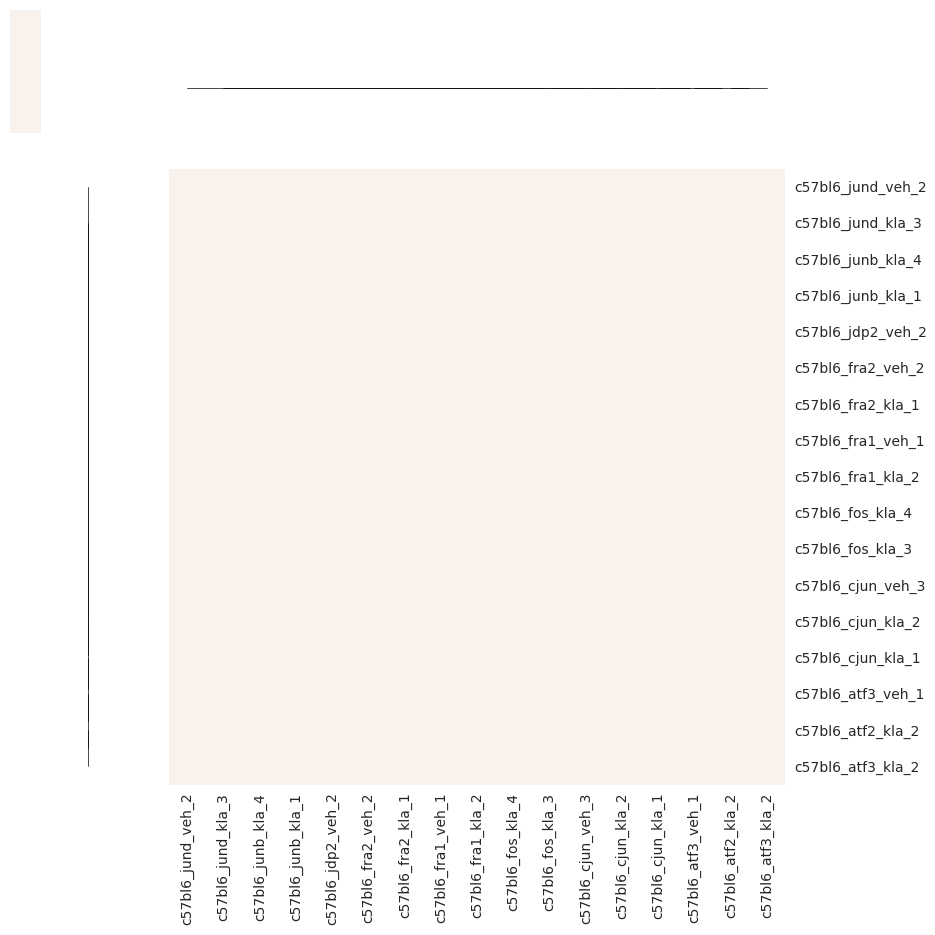

In [54]:
# for every pair of peak files
sns.clustermap(tag_pearson_matrix, xticklabels=simpleNames, yticklabels=simpleNames)

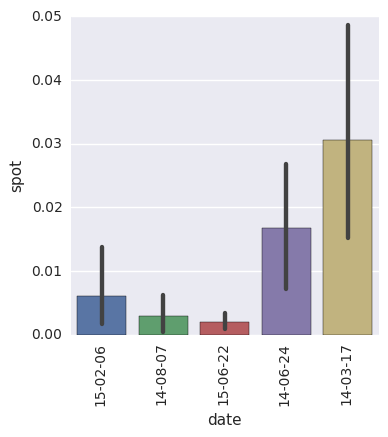

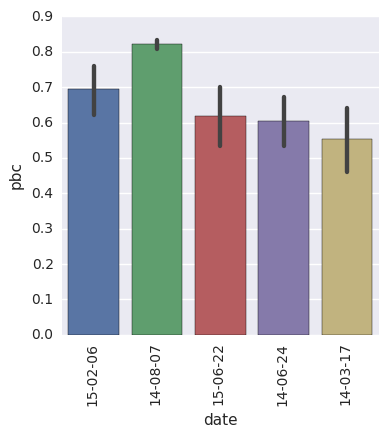

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

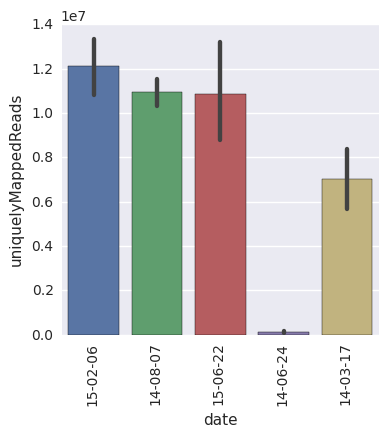

In [55]:
sns.factorplot(x='date',y='spot', data=summary_frame, kind='bar')
plt.xticks(rotation=90) 
plt.show()
sns.factorplot(x='date',y='pbc', data=summary_frame, kind='bar')
plt.xticks(rotation=90) 
plt.show()
sns.factorplot(x='date',y='uniquelyMappedReads', data=summary_frame, kind='bar')
plt.xticks(rotation=90) 

In [56]:
summary_frame[summary_frame['factor'] == 'JunD'][['treatment','date', 'originalName', 'sampleName','homer_peaks']]

KeyError: "['homer_peaks'] not in index"

In [ ]:
replicateIndices = []
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        replicateIndices.append(index)

# homer peaks
homer_peaks = filtered_summary_frame.loc[replicateIndices][['factor', 'simpleTreatment', 'homer_peaks']]
homer_peaks['peak_caller'] = 'homer'
homer_peaks.columns = ['factor', 'simpleTreatment', 'peaks', 'peak_caller']
# gem peaks
gem_peaks = filtered_summary_frame.loc[replicateIndices][['factor', 'simpleTreatment', 'gem_peaks']]
gem_peaks['peak_caller'] = 'gem'
gem_peaks.columns = ['factor', 'simpleTreatment', 'peaks', 'peak_caller']
# macs peaks
macs_peaks = filtered_summary_frame.loc[replicateIndices][['factor', 'simpleTreatment', 'macs_peaks']]
macs_peaks['peak_caller'] = 'macs'
macs_peaks.columns = ['factor', 'simpleTreatment', 'peaks', 'peak_caller']

sns.factorplot(x='simpleTreatment', y='peaks', row='factor', data = pd.concat([homer_peaks, gem_peaks, macs_peaks]), kind='strip', hue ='peak_caller')

In [ ]:
filtered_summary_frame.loc[replicateIndices]

## Run IDR

In [ ]:
homer = True
gem = False
macs = False

idrDirectory = '/home/jenhan/analysis/ap1_analysis/ap1_idr'
if not os.path.exists(idrDirectory):
    os.mkdir(idrDirectory)

# find the number of lines to skip
numRowsToSkip = 0
with open(peakDirectory +'/' + os.listdir(peakDirectory)[0]) as f:
    data = f.readlines()
for line in data:
    if line[0] == '#':
        numRowsToSkip +=1
    else:
        break
numRowsToSkip -= 1
print("Skipping first", numRowsToSkip, "rows")
for index in set(summary_frame.index):
    factor_treatment_rows = summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        simpleNames = factor_treatment_rows['simplifiedName'].values
        for i in range(len(simpleNames) - 1):
            for j in range(i+1, len(simpleNames)):
                simpleName1 = simpleNames[i]
                simpleName2 = simpleNames[j]
                print(simpleName1)
                print(simpleName2)

                # run IDR on Homer peak files
                # convert Homer peak files to narrow peak files
                homer_peaks_1 = pd.read_csv(peakDirectory + '/' + simpleName1 + '_homer_peaks.tsv',sep='\t', skiprows=numRowsToSkip)
                homer_peaks_2 = pd.read_csv(peakDirectory + '/' + simpleName2 + '_homer_peaks.tsv',sep='\t', skiprows=numRowsToSkip)
                homer_narrowPeak_1 = homer_peaks_1[['chr',
                                                    'start',
                                                    'end',
                                                    '#PeakID',
                                                    'findPeaks Score', 
                                                    'strand', 
                                                    'Normalized Tag Count',
                                                    'p-value vs Control']]
                homer_narrowPeak_1['qValue'] = '-1'
                homer_narrowPeak_1['peak'] = '-1'
                homer_narrowPeak_1.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak']

                homer_narrowPeak_2 = homer_peaks_2[['chr',
                                                    'start',
                                                    'end',
                                                    '#PeakID',
                                                    'findPeaks Score', 
                                                    'strand', 
                                                    'Normalized Tag Count',
                                                    'p-value vs Control']]
                homer_narrowPeak_2['qValue'] = '-1'
                homer_narrowPeak_2['peak'] = '-1'
                homer_narrowPeak_2.columns = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak']

                homer_narrowPeak_path_1 = idrDirectory + '/' +simpleName1 + '_homer.narrowPeak'
                homer_narrowPeak_path_2 = idrDirectory + '/' +simpleName2 + '_homer.narrowPeak'

                homer_narrowPeak_1.to_csv(homer_narrowPeak_path_1, sep='\t', header = False, index= False)
                homer_narrowPeak_2.to_csv(homer_narrowPeak_path_2, sep='\t', header = False, index= False)

                homer_idrPath = idrDirectory + '/' + simpleName1 + '_' + simpleName2 + '_homer_idr.out'
                !idr --plot --samples $homer_narrowPeak_path_1 $homer_narrowPeak_path_2 --output-file $homer_idrPath --use-old-output-format

                # run IDR on GEM peak files
                if gem:
                    gem_narrowPeak_path_1 = peakDirectory + '/' + simpleName1 + '_gem/' + simpleName1 + '_gem_GPS_events.narrowPeak'
                    gem_narrowPeak_path_2 = peakDirectory + '/' + simpleName2 + '_gem/' + simpleName2 + '_gem_GPS_events.narrowPeak'

                    gem_idrPath = idrDirectory + '/' + simpleName1 + '_' + simpleName2 + '_gem_idr.out'
                    !idr --plot --samples $gem_narrowPeak_path_1 $gem_narrowPeak_path_2 --output-file $gem_idrPath --use-old-output-format

                # run IDR on MACS peak files (already Narrow Peak)
                if macs:
                    macs_narrowPeak_path_1 = peakDirectory + '/' + simpleName1 + '_macs/' + simpleName1 + '_macs_peaks.narrowPeak'
                    macs_narrowPeak_path_2 = peakDirectory + '/' + simpleName2 + '_macs/' + simpleName2 + '_macs_peaks.narrowPeak'

                    macs_idrPath = idrDirectory + '/' + simpleName1 + '_' + simpleName2 + '_macs_idr.out'
                    !idr --plot --samples $macs_narrowPeak_path_1 $macs_narrowPeak_path_2 --output-file $macs_idrPath --use-old-output-format


        

In [ ]:
idr_threshold = 0.05
idr_threshold_score = min([int(-125*np.log2(idr_threshold)), 1000])

# homer peaks
homer_peaks = filtered_summary_frame.loc[replicateIndices][['factor', 'simpleTreatment', 'homer_peaks']]
homer_peaks['peak_caller'] = 'homer'
homer_peaks['idr'] = False
homer_peaks.columns = ['factor', 'simpleTreatment', 'peaks', 'peak_caller', 'idr']
homer_peaks.index=range(homer_peaks.shape[0])
# gem peaks
gem_peaks = filtered_summary_frame.loc[replicateIndices][['factor', 'simpleTreatment', 'gem_peaks']]
gem_peaks['peak_caller'] = 'gem'
gem_peaks['idr'] = False
gem_peaks.columns = ['factor', 'simpleTreatment', 'peaks', 'peak_caller', 'idr']
gem_peaks.index=range(gem_peaks.shape[0])
# macs peaks
macs_peaks = filtered_summary_frame.loc[replicateIndices][['factor', 'simpleTreatment', 'macs_peaks']]
macs_peaks['peak_caller'] = 'macs'
macs_peaks['idr'] = False
macs_peaks.columns = ['factor', 'simpleTreatment', 'peaks', 'peak_caller', 'idr']
macs_peaks.index=range(macs_peaks.shape[0])
# read in IDR values
for index in set(filtered_summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        simpleNames = factor_treatment_rows['simplifiedName'].values
        for i in range(len(simpleNames) - 1):
            for j in range(i+1, len(simpleNames)):
                simpleName1 = simpleNames[i]
                simpleName2 = simpleNames[j]
                
                # count peaks that pass threshold
                homer_idrPath = idrDirectory + '/' + simpleName1 + '_' + simpleName2 + '_homer_idr.narrowPeak'
                with open(homer_idrPath) as f:
                    data = f.readlines()
                count = 0
                for line in data:
                    tokens = line.strip().split("\t")
                    score = int(tokens[4])
                    if score > idr_threshold_score:
                        count += 1
                homer_peaks.loc[homer_peaks.shape[0]] = [index[0], index[1], count, 'homer', True]
                
                gem_idrPath = idrDirectory + '/' + simpleName1 + '_' + simpleName2 + '_gem_idr.narrowPeak'
                with open(gem_idrPath) as f:
                    data = f.readlines()
                count = 0
                for line in data:
                    tokens = line.strip().split("\t")
                    score = int(tokens[4])
                    if score > idr_threshold_score:
                        count += 1
                gem_peaks.loc[gem_peaks.shape[0]] = [index[0], index[1], count, 'gem', True]
                
                macs_idrPath = idrDirectory + '/' + simpleName1 + '_' + simpleName2 + '_macs_idr.narrowPeak'
                with open(macs_idrPath) as f:
                    data = f.readlines()
                count = 0
                for line in data:
                    tokens = line.strip().split("\t")
                    score = int(tokens[4])
                    if score > idr_threshold_score:
                        count += 1
                macs_peaks.loc[macs_peaks.shape[0]] = [index[0], index[1], count, 'macs', True]        
sns.factorplot(x='peak_caller', y='peaks', row='factor', data = pd.concat([homer_peaks, gem_peaks, macs_peaks]), kind='point', hue ='idr')


In [ ]:


idr_threshold = 0.05
idr_threshold_score = min([int(-125*np.log2(idr_threshold)), 1000])
def convert_narrowPeak_to_homerPeak(inputPath, outputPath, threshold):
    '''
    converts narrow peak files to Homer files
    '''
    narrowPeak_frame = pd.read_csv(inputPath, sep='\t')
    narrowPeak_frame = narrowPeak_frame.iloc[:,:10]
    narrowPeak_frame.columns = ['chrom', 'chromStart', 'chromEnd', '#PeakID', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak']
    narrowPeak_frame = narrowPeak_frame[narrowPeak_frame['score'] >= threshold]
    narrowPeak_frame = narrowPeak_frame[['#PeakID','chrom', 'chromStart', 'chromEnd','strand', 'score', 'signalValue', 'pValue']]
    if '.' in narrowPeak_frame['#PeakID'].values:
        rand = np.random.randint(0,1000)
        narrowPeak_frame['#PeakID'] = [str(rand) + '_'+ str(x) for x in np.array(range(narrowPeak_frame.shape[0]))]
    if '.' in narrowPeak_frame['strand'].values:
        narrowPeak_frame['strand'] = '+'
    narrowPeak_frame.to_csv(outputPath, index= False, sep='\t')
    
for index in set(summary_frame.index):
    factor_treatment_rows = filtered_summary_frame.loc[index]
    if len(factor_treatment_rows) > 1:       
        simpleNames = factor_treatment_rows['simplifiedName'].values
        for i in range(len(simpleNames) - 1):
            for j in range(i+1, len(simpleNames)):
                simpleName1 = simpleNames[i]
                simpleName2 = simpleNames[j]
                
                # convert peaks that pass threshold
                homer_idrPath = idrDirectory + '/' + simpleName1 + '_' + simpleName2 + '_homer_idr.narrowPeak'
                gem_idrPath = idrDirectory + '/' + simpleName1 + '_' + simpleName2 + '_gem_idr.narrowPeak'
                macs_idrPath = idrDirectory + '/' + simpleName1 + '_' + simpleName2 + '_macs_idr.narrowPeak'


                convert_narrowPeak_to_homerPeak(homer_idrPath, homer_idrPath.replace('narrowPeak','homerPeak'), idr_threshold_score)
                convert_narrowPeak_to_homerPeak(gem_idrPath, gem_idrPath.replace('narrowPeak','homerPeak'), idr_threshold_score)
                convert_narrowPeak_to_homerPeak(macs_idrPath, macs_idrPath.replace('narrowPeak','homerPeak'), idr_threshold_score)

                homer_narrowPeak_path_1 = idrDirectory + '/' +simpleName1 + '_homer.narrowPeak'
                homer_narrowPeak_path_2 = idrDirectory + '/' +simpleName2 + '_homer.narrowPeak'
                convert_narrowPeak_to_homerPeak(homer_narrowPeak_path_1, 
                                                homer_narrowPeak_path_1.replace(peakDirectory, idrDirectory).replace('narrowPeak','homerPeak'),
                                                0)
                convert_narrowPeak_to_homerPeak(homer_narrowPeak_path_2, 
                                                homer_narrowPeak_path_2.replace(peakDirectory, idrDirectory).replace('narrowPeak','homerPeak'),
                                                0)
                # run IDR on GEM peak files
                gem_narrowPeak_path_1 = peakDirectory + '/' + simpleName1 + '_gem/' + simpleName1 + '_gem_GPS_events.narrowPeak'
                gem_narrowPeak_path_2 = peakDirectory + '/' + simpleName2 + '_gem/' + simpleName2 + '_gem_GPS_events.narrowPeak'
                convert_narrowPeak_to_homerPeak(gem_narrowPeak_path_1, 
                                                idrDirectory + '/' +simpleName1 + '_macs.homerPeak',
                                                0)
                convert_narrowPeak_to_homerPeak(gem_narrowPeak_path_2, 
                                                idrDirectory + '/' +simpleName2 + '_macs.homerPeak',
                                                0)
                # run IDR on MACS peak files (already Narrow Peak)
                macs_narrowPeak_path_1 = peakDirectory + '/' + simpleName1 + '_macs/' + simpleName1 + '_macs_peaks.narrowPeak'
                macs_narrowPeak_path_2 = peakDirectory + '/' + simpleName2 + '_macs/' + simpleName2 + '_macs_peaks.narrowPeak'
                
                convert_narrowPeak_to_homerPeak(macs_narrowPeak_path_1, 
                                                idrDirectory + '/' +simpleName1 + '_macs.homerPeak',
                                                0)
                convert_narrowPeak_to_homerPeak(macs_narrowPeak_path_2, 
                                                idrDirectory + '/' +simpleName2 + '_macs.homerPeak',
                                                0)


In [ ]:
print(summary_frame['homer_peaks'].to_string())

In [ ]:
summary_frame.index